### <div align="center">Model Evaluation & Fine Tuning</div>

##### 6.2: Model Evaluation - ROC (Receiver Operating Characteristic) Curve & AUC (Area Under Curve)
- ROC curve: A graph showing the performance of a classification (Specially Binary Classification Model) model by plotting the true positive rate against the false positive rate at various threshold settings.
- In Healthcare use cases we need high recall means if person has issue we want to capture that. In case spam email precision should be high, it means important email should not go to spam folder.
- AUC: A metric that measures the entire two-dimensional area underneath the ROC curve, representing the model’s ability to distinguish between classes.
When dealing with stakeholders with model metrics (ROC, AUC, precision, etc.), they won’t understand. The more AUC the better is model performance.
- As a data scientist, it is an important skill to translate these metrics into business metrics and discuss in those terms to really make them understand what is the impact.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_features=10, 
    n_samples=1000, 
    n_informative=4,
    n_redundant=6,
    n_repeated=0,
    n_classes=2, 
    random_state=42
)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
# Now Train XGBoost Model
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       122
           1       0.93      0.89      0.91       128

    accuracy                           0.91       250
   macro avg       0.91      0.91      0.91       250
weighted avg       0.91      0.91      0.91       250



Out of the box, it gives us 89% recall which is pretty good but now my business manager becomes greedy and asks for 92% recall.

In [7]:
from sklearn.metrics import roc_curve
probabilities_xgb = model.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, probabilities_xgb)

fpr_xgb[:5], tpr_xgb[:5], thresholds_xgb[:5]

(array([0.        , 0.        , 0.        , 0.00819672, 0.00819672]),
 array([0.       , 0.0078125, 0.09375  , 0.09375  , 0.203125 ]),
 array([       inf, 0.99996376, 0.99989676, 0.999892  , 0.9997204 ],
       dtype=float32))

In [9]:
from sklearn.metrics import auc
area2 = auc(fpr_xgb, tpr_xgb)
area2

0.946016905737705

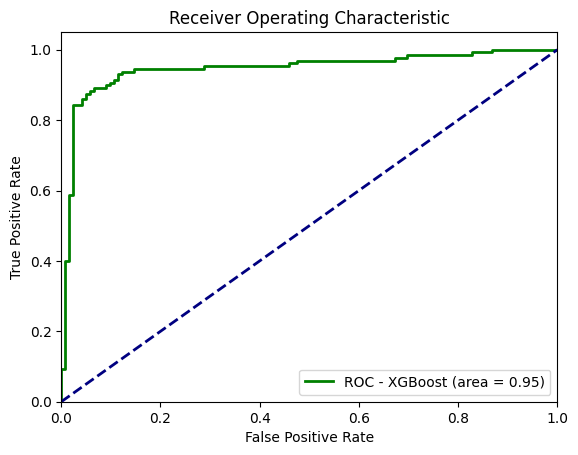

In [11]:
# Plot ROC Curve for XGBoost
plt.figure()

plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label='ROC - XGBoost (area = %0.2f)' % area2)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [12]:
desired_recall = 0.92

closest_index = np.argmin(abs(tpr_xgb-desired_recall))
tpr_xgb[closest_index], thresholds_xgb[closest_index], fpr_xgb[closest_index]

(0.9140625, 0.30599597, 0.10655737704918032)

Threshold associated with 92% recall is 0.3, we will incorporate this in our inference code and deploy the model. Note that with this we will get a false positive rate of around 10% (0.106)

##### 6.6: K Fold Cross Validation
- K-fold cross-validation is a method where the dataset is split into k subsets (or folds). The model is trained on k-1 folds and tested on the remaining fold. This process is repeated k times, ensuring each fold is used once as the test set, giving a reliable estimate of model performance.
- Cross-validation can also be used with the same model but with different parameters.
##### 6.7: Stratified K Fold Cross Validation
- Stratified K-Fold Cross Validation is a technique that divides data into K subsets while preserving the percentage of samples for each class, ensuring each fold is representative of the entire dataset.

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split([50,60,70,80,90]):
    print(train_index, test_index)

In [ ]:
model = LogisticRegression()

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]  
    model.fit(X_train, y_train)
    print(model.score(X_test, y_test))

In [ ]:
# Cross validation on Logistic Regression
from sklearn.model_selection import cross_val_score

cross_val_score(LogisticRegression(), X, y, cv=kf, scoring="accuracy")

##### 6.8: Hyperparameter Tuning: GridSearchCV
- Hyperparameter Tuning with GridSearchCV involves thoroughly searching a specified parameter grid to identify the best hyperparameter combination for a machine learning model. This is done by evaluating performance through cross-validation.
- We should express our gratitude to the open-source contributors who have enhanced scikit-learn, making the work of ML and Data scientists more efficient.

##### 6.9: Hyperparameter Tuning: RandomizedSearchCV
- The issue with GridSearchCV is that we need to try out all the combination which is quite expensive.
- RandomizedSearchCV is useful when we have huge data and no of parameter want to try is huge.
- RandomizedSearchCV is a technique that searches over random combinations of hyperparameters to find the best model configuration using cross-validation, making it more efficient than exhaustive methods.
- To optimize computation, we primarily use RandomizedSearchCV. By adjusting just the n_iter parameter, it functions identically to GridSearchCV.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_features=10, 
    n_samples=1000, 
    n_informative=8,
    n_redundant=2,
    n_repeated=0,
    n_classes=2, 
    random_state=42
)

##### RandomizedSearchCV
- Use RandomizedSearchCV to reduce number of iterations and with random combination of parameters. This is useful when you have too many parameters to try and your training time is longer. It helps reduce the cost of computation

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

clf = RandomizedSearchCV(
    DecisionTreeClassifier(),
    {'criterion': ["gini", "entropy"],'max_depth': [5, 10, 15, 20]},
    cv=5,
    return_train_score=False,
    n_iter=3 
)
clf.fit(X, y)
df = pd.DataFrame(clf.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005551,0.006892,0.000819,0.001639,20,gini,"{'max_depth': 20, 'criterion': 'gini'}",0.795,0.725,0.82,0.82,0.820,0.796,0.036797,2
1,0.007714,0.007240,0.000000,0.000000,5,entropy,"{'max_depth': 5, 'criterion': 'entropy'}",0.765,0.785,0.76,0.81,0.775,0.779,0.017720,3
2,0.008248,0.000336,0.000144,0.000287,15,entropy,"{'max_depth': 15, 'criterion': 'entropy'}",0.760,0.800,0.83,0.81,0.875,0.815,0.037683,1


##### 6.12: Model Selection Guide
- Machine learning is both a science and an art. As an ML practitioner, you need to use your judgment to choose the right model for each situation.
- Since there is no perfect decision tree for model selection, the process can be broadly divided into problem type, column relationships, data type, and data size. Refer to the attached PDF for a detailed guide.

In [1]:
from IPython.display import IFrame

IFrame(src='../../documents/model_selection_guide.pdf', width=1000, height=400)

6.13: Selecting the Right Evaluation Metric
- When we print the report we see 2 more parameter (apart from precision, recall etc.) macro avg (Useful in case of balance classes) and weighted avg (Useful in case of class imbalance).
- Classifications:
  1. Accuracy: Assesses the overall correctness of the model. Particularly useful when classes are balanced.
  2. Precision: Indicates the reliability of positive predictions, especially important when false positives are costly.
  3. Recall: Focuses on capturing as many positives as possible, crucial when missing a positive is costly.
  4. AUC-ROC: Measures how well the model ranks positive instances higher than negative ones.
  5. F1 Score: Balances precision and recall, providing a comprehensive performance metric.
  6. Confusion Matrix: Offers insights into where the model is making errors, aiding in the assessment of accuracy, precision, recall, and other performance metrics.
- Regressions:
  1. MSE (Mean Squared Error): Highlights significant errors and is sensitive to outliers.
  2. RMSE (Root Mean Square Error): Offers easier interpretation.
  3. R² value: Indicates goodness of fit and measures the proportion of variance in the dependent variable predictable from the independent variables.